- [EDA](#eda)
  - source: https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- [Data preprocessing](#pre_proc)

### Explanatory Data Analysis<a id="eda"></a>

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
#importing the dataset
train=pd.read_csv(r"C:\Users\User\Desktop\MSc Courses\Deep Learning\Assignment\data\train.csv")
test=pd.read_csv(r"C:\Users\User\Desktop\MSc Courses\Deep Learning\Assignment\data\test.csv")

In [23]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


Train and Test samples

In [24]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


Clean vs Tags
<br>
We observe that the dataset is unbalanced

In [61]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums = train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


Check for missing values

In [25]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


We observe that even tha tags are imbalanced

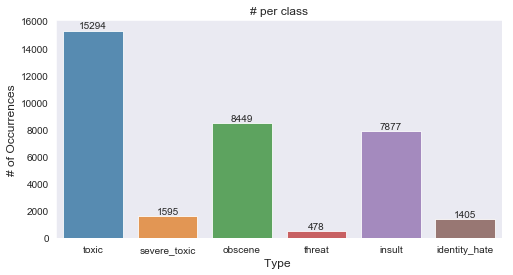

In [26]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

We observe that there are multitagged comments

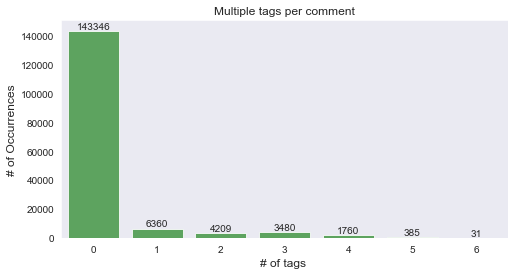

In [63]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Patterns of co-occurance

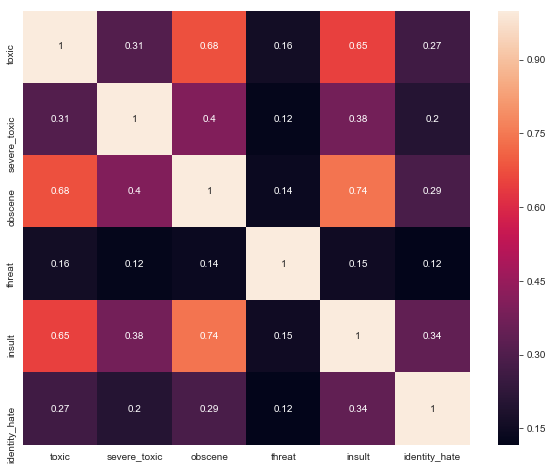

In [64]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

### Data Preprocessing<a id="pre_proc"></a>

 - source: https://github.com/zake7749/DeepToxic/blob/master/baselines/LogisticRegression.ipynb

In [28]:
from collections import defaultdict
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.sparse import hstack
from scipy.special import logit, expit

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#importing the dataset
datasets_path = r"C:\Users\User\Desktop\MSc Courses\Deep Learning\Assignment\data\\"
train = pd.read_csv(datasets_path + 'train.csv').fillna(' ')
test = pd.read_csv(datasets_path + 'test.csv').fillna(' ')

list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']
all_text = pd.concat([list_sentences_train, list_sentences_test])

In [17]:
cl_path = r'C:\Users\User\Desktop\MSc Courses\Deep Learning\Assignment\cleanwords.txt'
clean_word_dict = {}
with open(cl_path, 'r', encoding='utf-8') as cl:
    for line in cl:
        line = line.strip('\n')
        typo, correct = line.split(',')
        clean_word_dict[typo] = correct

In [19]:
########################################
## process texts in datasets
########################################
print('Processing text dataset')
# Regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^?!.,:a-z\d ]',re.IGNORECASE)

# regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)
word_count_dict = defaultdict(int)
toxic_dict = {}

def clean_text(text, remove_stopwords=False, stem_words=False, count_null_words=True, clean_wiki_tokens=True):
    # Clean the text, with the option to remove stopwords and to stem words.
    # dirty words
    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)
    
    if clean_wiki_tokens:
        # Drop the image
        text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)

        # Drop css
        text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
        text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
        
        # Clean templates
        text = re.sub(r"\[?\[user:.*\]", " ", text)
        text = re.sub(r"\[?\[user:.*\|", " ", text)        
        text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
        text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
        text = re.sub(r"\[?\[special:.*\]", " ", text)
        text = re.sub(r"\[?\[special:.*\|", " ", text)
        text = re.sub(r"\[?\[category:.*\]", " ", text)
        text = re.sub(r"\[?\[category:.*\|", " ", text)
    
    for typo, correct in clean_word_dict.items():
        text = re.sub(typo, " " + correct + " ", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = replace_numbers.sub(' ', text)
    #text = special_character_removal.sub('',text)

    if count_null_words:
        text = text.split()
        for t in text:
            word_count_dict[t] += 1
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    return (text)

list_sentences_train = train["comment_text"].fillna("no comment").values
list_sentences_test = test["comment_text"].fillna("no comment").values

comments = [clean_text(text) for text in list_sentences_train]    
test_comments=[clean_text(text) for text in list_sentences_test]

print("Cleaned.")

Processing text dataset
Cleaned.


In [29]:
train['comment_text'] = comments
test['comment_text'] = test_comments
train.to_csv(datasets_path + 'cleaned_train.csv', index=False)
test.to_csv(datasets_path + 'cleaned_test.csv', index=False)